In [2]:
import pandas as pd
import numpy as np
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D, MaxPool2D, CuDNNGRU, GlobalMaxPool2D, Reshape, \
concatenate, Input, TimeDistributed, Dense, BatchNormalization, SpatialDropout2D, SpatialDropout1D, Dropout, GlobalAvgPool2D, Flatten
from keras import Model
from keras.applications import Xception
import keras.backend as k
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


-0.03514303
61.88129


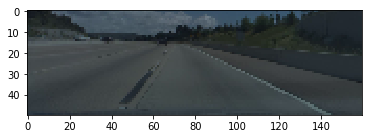

In [3]:
hdf5_path = './train_data/train.hdf5'
with h5py.File(hdf5_path, "r") as f:
    print(f["op_flow"][1].mean())
    train_size = len(f["speed"])
    print(f["frame"][5].mean())
    plt.imshow(f["frame"][5]/255)
    speed_data = list(f["speed"])
#     for i in range(train_size,train_size - 100):
        
#         frame, axarr = plt.subplots(1,2)
#         axarr[0].imshow(f["frame"][i])
#         axarr[1].imshow(f["op_flow"][i])
#         print(f['speed'][i])
#         plt.show()
#     plt.plot(speed_data)

0.06912127
2.206759
20401


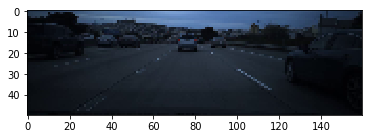

In [4]:
hdf5_path_comma = './train_data/comma_train.hdf5'
with h5py.File(hdf5_path_comma, "r") as f:
    print(f["op_flow"][1].mean())
    plt.imshow(f["frame"][6500]/255)
    print(f['speed'][-1])
    print(len(f["speed"]))
    comma_train_size = len(f["speed"])
    comma_speed_data = list(f["speed"])

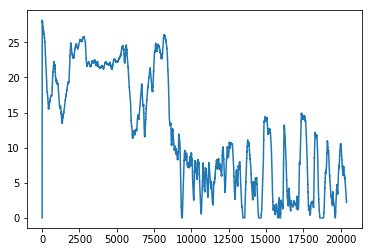

In [5]:
plt.plot(comma_speed_data)

In [6]:
print(train_size, comma_train_size)

103787 20401


In [7]:
import time
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, history_size, hdf5_path, indexes = None, validation_mode = False):
        self.hdf5_path = hdf5_path
        if indexes is None:
            with h5py.File(self.hdf5_path, "r") as f:
                self.indexes = np.arange(len(f["speed"]))
        else:
            self.indexes = indexes
        self.batch_size = batch_size
        self.history_size = history_size
        self.validation_mode = validation_mode
        if self.validation_mode == False:
            print("shuffling")
            self.on_epoch_end()
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.validation_mode == False:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'
        indexes = list(indexes)
        indexes.sort()
        frame = np.zeros((self.batch_size, 224, 224, 3))
        op_flow = np.zeros((self.batch_size, 50, 160, 2))
        speed = np.zeros((self.batch_size, 1))
        with h5py.File(self.hdf5_path, "r") as f:
            #self.frame = np.array(f["frame"][indexes])[batch_shuffles]
            op_flow = np.array(f["op_flow"][indexes])
            speed = np.array(f["speed"][indexes])
                
        return [
            #frame,
            op_flow], speed

In [8]:
train_indexes, val_indexes = train_test_split(np.arange(int(train_size)), shuffle = False, test_size = .2)
comma_train_indexes, comma_val_indexes = train_test_split(np.arange(int(comma_train_size) - 1), shuffle = False, test_size = .2)

In [9]:
time_history = 1

In [10]:
comma_train_indexes_no_shuf = np.copy(comma_train_indexes)
comma_train_generator_no_shuf = DataGenerator(32, time_history, hdf5_path_comma, indexes = comma_train_indexes_no_shuf, validation_mode = True)
comma_val_indexes_no_shuf = np.copy(comma_val_indexes)
comma_val_generator_no_shuf = DataGenerator(32, time_history, hdf5_path_comma, indexes = comma_val_indexes_no_shuf, validation_mode = True)

In [11]:

train_generator = DataGenerator(32, time_history, hdf5_path, indexes = train_indexes)
valid_generator = DataGenerator(32, time_history, hdf5_path, indexes = val_indexes, validation_mode = True)

comma_train_generator = DataGenerator(32, time_history, hdf5_path_comma, indexes = comma_train_indexes)

shuffling
shuffling


In [17]:
def build_model_flat(history_size):
    k.clear_session()
    #frame_inp = Input(shape=(224, 224, 3))
    op_flow_inp = Input(shape=(50, 160, 2))
    filters = [3, 5]
    op_flows = []
    #op_flow = BatchNormalization()(op_flow_inp)
    op_flow = (op_flow_inp)
    for i, filter_size in enumerate(filters):
        int_layer = Dropout(.2)(op_flow)
        int_layer = Conv2D(8, (filter_size,filter_size), activation = "relu", data_format = "channels_last")(int_layer)
        int_layer = MaxPool2D(pool_size = (1,2))(int_layer)
        int_layer = Conv2D(16, (filter_size,filter_size), activation = "relu", data_format = "channels_last")(int_layer)
        int_layer = MaxPool2D(pool_size = (1,2))(int_layer)
        int_layer = Conv2D(32, (filter_size,filter_size), activation = "relu", data_format = "channels_last")(int_layer)
        int_layer = Conv2D(64, (filter_size,filter_size), activation = "relu", data_format = "channels_last")(int_layer)
        #int_layer = Dropout(.3)(int_layer)
        int_layer = Conv2D(128, (filter_size,filter_size), activation = "relu", data_format = "channels_last")(int_layer)
        int_layer = MaxPool2D()(int_layer)
        int_layer = Conv2D(256, (filter_size,filter_size), activation = "relu", data_format = "channels_last")(int_layer)
        int_layer = MaxPool2D()(int_layer)
        int_layer = Conv2D(512, (filter_size,filter_size), activation = "relu",
                           data_format = "channels_last", padding = "same")(int_layer)
        int_layer = MaxPool2D()(int_layer)
        int_layer_max = GlobalMaxPool2D()(int_layer)
        int_layer_avg = GlobalAvgPool2D()(int_layer)
        conc = concatenate([int_layer_max, int_layer_avg])
        op_flows.append(conc)
    conc = concatenate(op_flows)
    #conc = BatchNormalization()(conc)
    #conc = SpatialDropout1D(.2)(conc)
    #conc = CuDNNGRU(256)(conc)
#     conc = Dropout(.2)(conc)
    conc = Dense(500, activation = "relu")(conc)
#     conc = Dropout(.2)(conc)
    conc = Dense(250, activation = "relu")(conc)
#     conc = Dropout(.1)(conc)
    result = Dense(1, activation='linear')(conc)
    
    model = Model(inputs=[
        #frame_inp,
        op_flow_inp], outputs=[result])
    print(model.summary())
    model.compile(loss="mse", optimizer='adam')

    return model

In [23]:
model_flat = build_model_flat(time_history)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 160, 2)   0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 160, 2)   0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 50, 160, 2)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 158, 8)   152         dropout_1[0][0]                  
__________________________________________________________________________________________________
conv2d_8 (

In [19]:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

In [20]:
def evaluate_metrics(y_true, y_pred):
    print(pd.DataFrame(y_pred).describe())
    print(mean_squared_error(y_true, y_pred))
    plt.plot(y_true)
    plt.plot(y_pred)
    plt.show()
    for j in range(1,21,5):
        rolling_preds = runningMeanFast(y_pred, j)
        print(mean_squared_error(y_true, rolling_preds))
    plt.plot(y_true)
    plt.plot(rolling_preds)
    plt.show()
    

Epoch 1/1
2595/2595 [==============================] - 305s 117ms/step - loss: 35.2488
custom valid metrics
                  0
count  20758.000000
mean      13.995740
std        9.157823
min       -1.197373
25%        6.599343
50%       15.224711
75%       21.061626
max       36.073154
27.43703


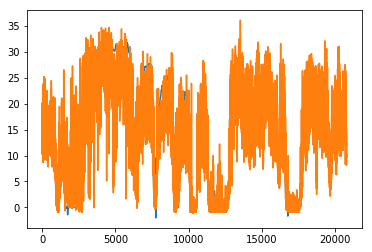

27.437029889284485
20.343854686579597
19.002960941811253
18.311718504942043


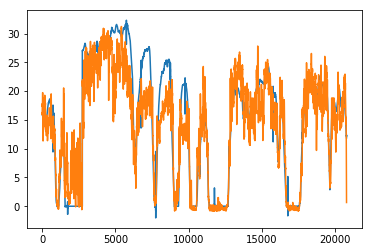

comma train metrics
                  0
count  16320.000000
mean      15.070375
std        8.054899
min       -1.304907
25%        8.422398
50%       16.908394
75%       21.729537
max       33.372173
32.54205


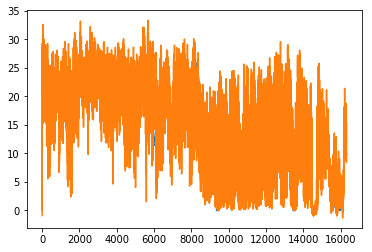

32.54204821317254
21.860220388113678
20.155312747980833
19.26564044844678


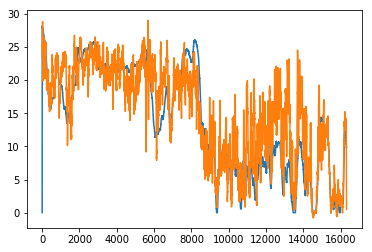

comma valid metrics
128/128 [==============================] - 1s 11ms/step
                 0
count  4080.000000
mean      6.724751
std       5.125200
min      -0.937456
25%       1.917105
50%       6.139217
75%      10.600794
max      24.185944
12.089879


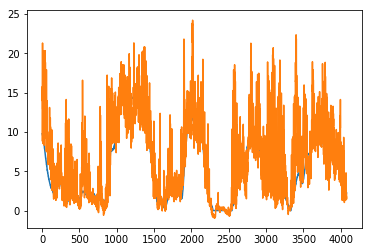

12.089879326979649
8.328404439096081
7.688664284849259
7.297824236917693


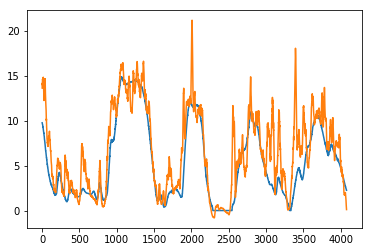

Epoch 1/1
2595/2595 [==============================] - 303s 117ms/step - loss: 15.7347
custom valid metrics
                  0
count  20758.000000
mean      12.868429
std        9.415287
min       -1.388337
25%        4.528403
50%       13.318164
75%       19.336047
max       32.926521
28.438269


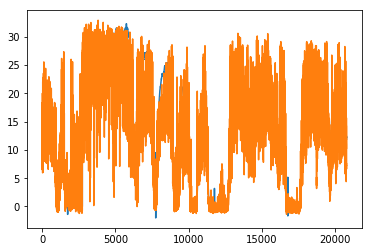

28.438268919606106
20.1408782103801
18.89955827744327
18.34103293240183


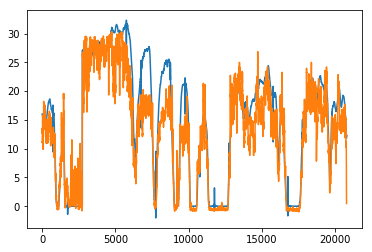

comma train metrics
                  0
count  16320.000000
mean      13.674563
std        9.397443
min       -1.011262
25%        4.365988
50%       14.102711
75%       22.021899
max       32.547272
34.07513


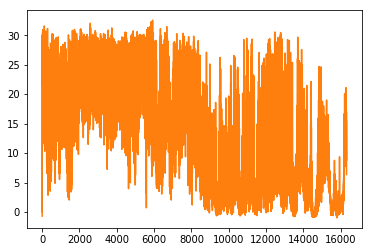

34.07513016681972
20.07148029990801
17.452482617204243
16.28052089367528


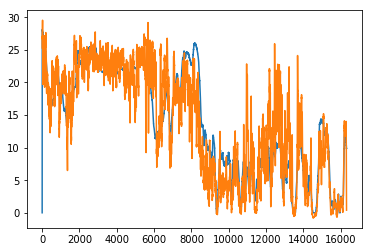

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.213653
std       4.839964
min      -1.168129
25%       1.293864
50%       3.752122
75%       8.640596
max      26.527292
6.0528293


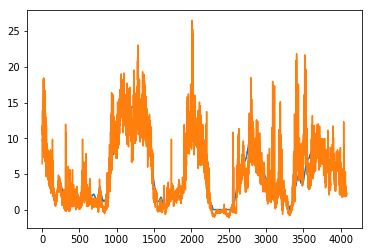

6.052829357753927
3.997723872677354
3.6075042515372466
3.3740512793173596


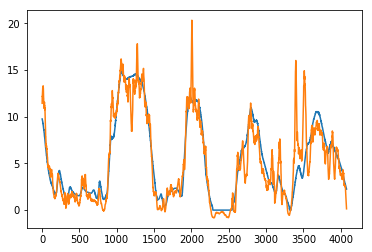

Epoch 1/1
2595/2595 [==============================] - 310s 119ms/step - loss: 11.8660
custom valid metrics
                  0
count  20758.000000
mean      14.363113
std        9.131166
min        0.370882
25%        6.630316
50%       15.314442
75%       20.695286
max       32.933327
21.403696


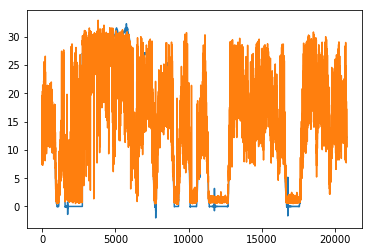

21.403698537795893
14.31002053047703
13.163162786603046
12.611308455177737


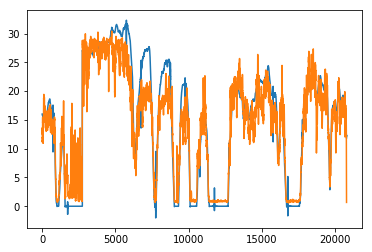

comma train metrics
                  0
count  16320.000000
mean      14.064215
std        8.979510
min        0.444213
25%        5.570315
50%       13.845425
75%       22.285133
max       31.860023
32.29204


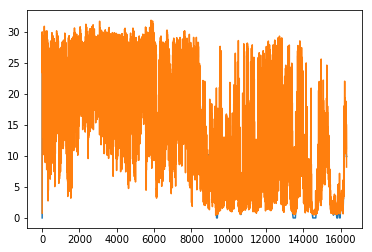

32.29204430271043
18.261088708608458
15.6134361780614
14.524204425957953


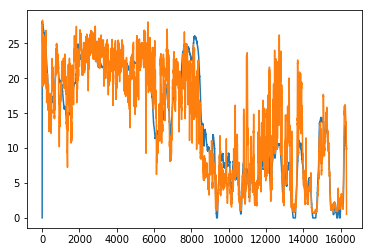

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      6.336684
std       4.801351
min       0.389306
25%       2.160776
50%       5.016505
75%       9.798777
max      27.267113
5.3153625


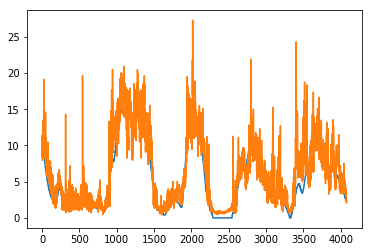

5.315362490661316
3.7544608161883692
3.4531804537682924
3.2747060407834905


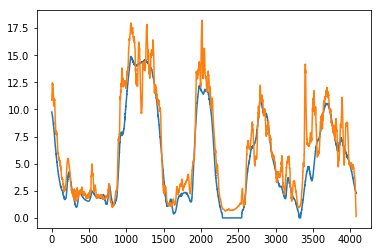

Epoch 1/1
2595/2595 [==============================] - 303s 117ms/step - loss: 9.5259
custom valid metrics
                  0
count  20758.000000
mean      13.069050
std        9.259194
min       -2.091764
25%        5.157222
50%       13.327521
75%       19.305413
max       32.103405
28.686907


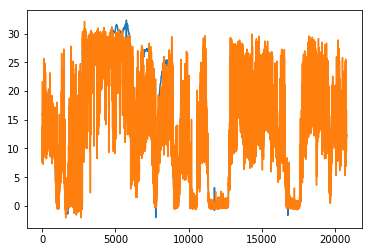

28.686905550550012
21.25112441416876
20.11173582991182
19.634046907853033


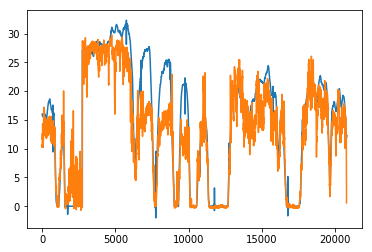

comma train metrics
                  0
count  16320.000000
mean      14.897904
std        9.108698
min       -0.971263
25%        6.494778
50%       15.176897
75%       23.779448
max       31.187958
39.870674


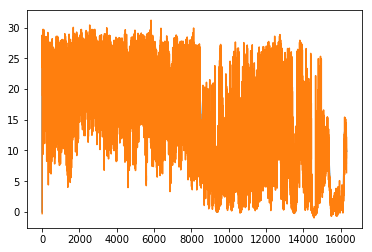

39.87067061102238
25.24287110322296
22.683854206337447
21.510636190308908


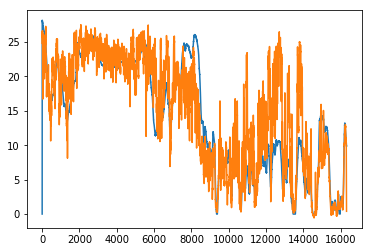

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.098040
std       4.190405
min      -0.683394
25%       1.587905
50%       4.105597
75%       7.890780
max      28.196978
4.1098113


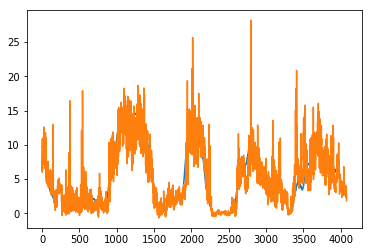

4.109811084541397
2.4021400445025796
2.116724591236476
1.9689673285230767


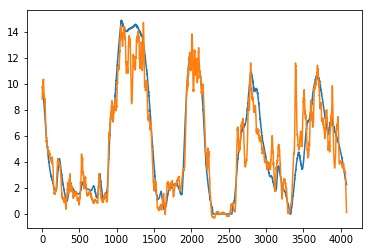

Epoch 1/1
2595/2595 [==============================] - 303s 117ms/step - loss: 8.2091
custom valid metrics
                  0
count  20758.000000
mean      13.458638
std        9.654927
min       -0.810996
25%        4.566652
50%       13.897462
75%       19.758886
max       33.404591
26.192747


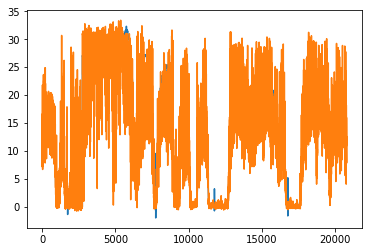

26.192747945558814
18.060518041908857
16.837194518752
16.3288543726671


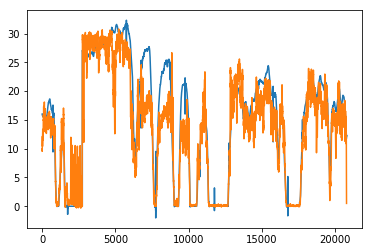

comma train metrics
                  0
count  16320.000000
mean      14.501802
std       10.550876
min       -0.699578
25%        3.531678
50%       14.656292
75%       25.314829
max       32.354824
44.446358


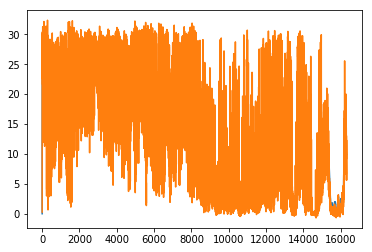

44.44635805032252
25.42510143020468
22.116461507173234
20.71998114648169


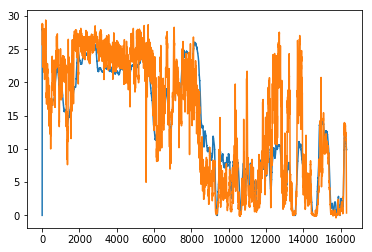

comma valid metrics
128/128 [==============================] - 1s 11ms/step
                 0
count  4080.000000
mean      4.952319
std       5.074633
min      -0.452057
25%       0.729287
50%       2.995394
75%       8.606430
max      28.445276
6.6357746


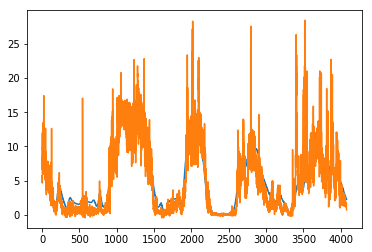

6.635774691307254
4.302353448226712
3.86755308207836
3.59525802060873


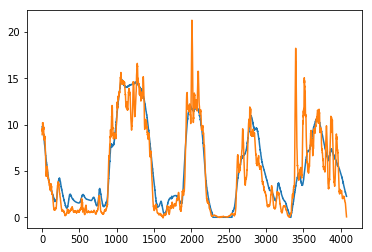

Epoch 1/1
2595/2595 [==============================] - 304s 117ms/step - loss: 7.0438
custom valid metrics
                  0
count  20758.000000
mean      13.666865
std        9.856903
min       -1.110443
25%        4.819169
50%       14.195072
75%       20.264077
max       33.965324
26.81611


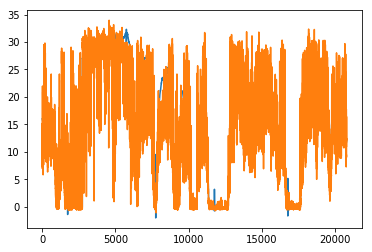

26.81610896658629
18.693791840644046
17.446054991802633
16.89926614721934


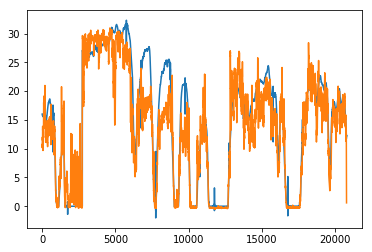

comma train metrics
                  0
count  16320.000000
mean      15.315030
std       10.403077
min       -0.783222
25%        4.940657
50%       15.600615
75%       25.948880
max       34.422913
53.52247


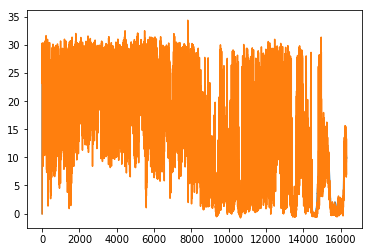

53.522467806359835
34.53883922265018
31.230508510922782
29.74932142694


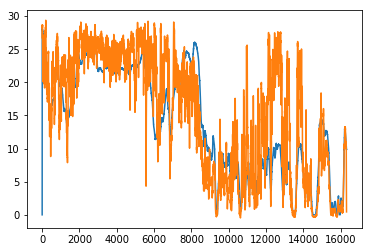

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      4.785699
std       4.659889
min      -0.561773
25%       0.917271
50%       3.177568
75%       8.117337
max      27.467499
5.6947746


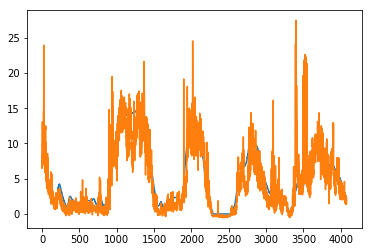

5.694774008111723
3.768499247869556
3.428030147155151
3.2138179690458797


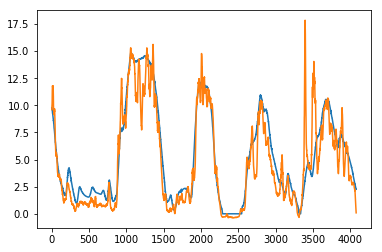

Epoch 1/1
2595/2595 [==============================] - 308s 119ms/step - loss: 6.5462
custom valid metrics
                  0
count  20758.000000
mean      14.381258
std        9.656777
min       -0.509434
25%        6.053918
50%       15.329195
75%       21.413894
max       33.116589
23.511936


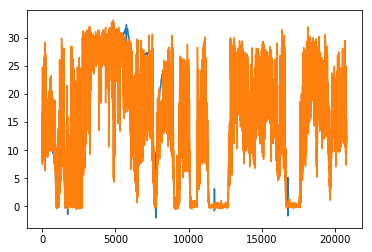

23.511935163653504
16.970572910035266
15.819383104781483
15.263633594843219


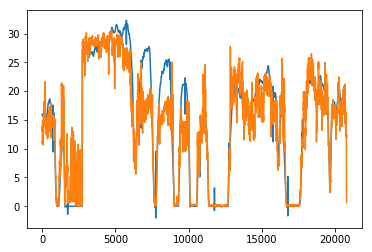

comma train metrics
                  0
count  16320.000000
mean      16.720335
std       10.227386
min       -0.545411
25%        6.398582
50%       19.440150
75%       26.363662
max       31.900080
62.029564


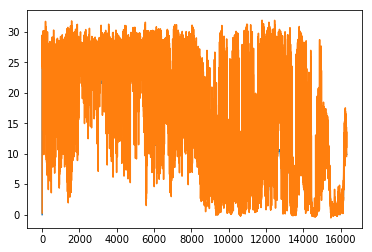

62.02956349688649
45.641813241080875
42.72725400849434
41.145724864889516


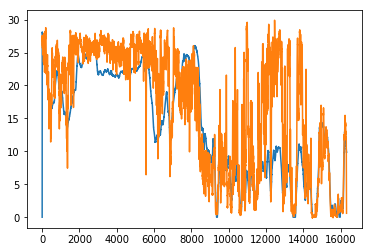

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.970434
std       5.186152
min      -0.221067
25%       1.412426
50%       4.695956
75%       9.688664
max      29.535807
8.463913


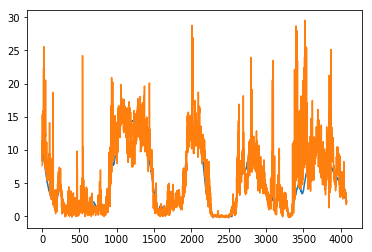

8.463912651307309
5.731155591069682
5.278649354936462
5.007032946145088


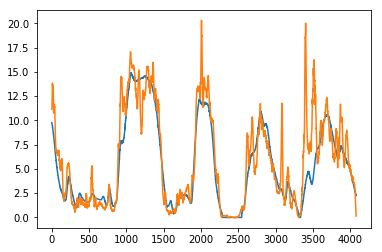

Epoch 1/1
2595/2595 [==============================] - 310s 119ms/step - loss: 5.8207
custom valid metrics
                  0
count  20758.000000
mean      14.852279
std       10.130866
min       -0.897227
25%        5.688043
50%       16.005078
75%       22.421195
max       33.427826
21.70012


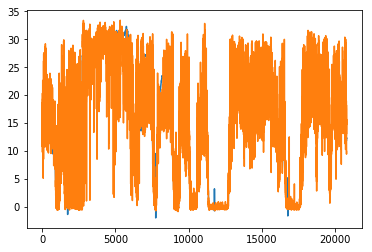

21.70012198687771
13.404094291151264
12.1493578742908
11.569986660030455


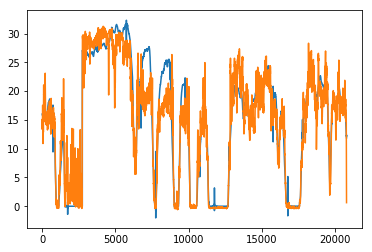

comma train metrics
                  0
count  16320.000000
mean      18.183401
std       10.875047
min       -0.955975
25%        7.478333
50%       22.371992
75%       27.991499
max       33.957573
70.99456


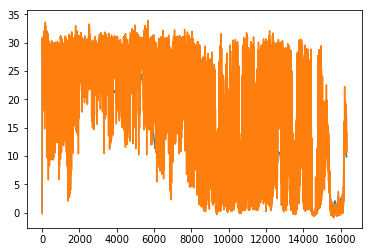

70.99456563098876
50.91646350880733
47.88932743441487
46.38517984010471


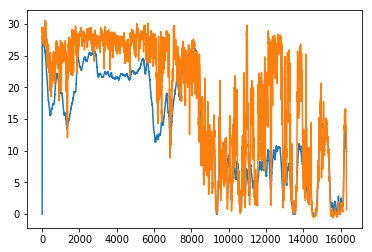

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.700974
std       5.918910
min      -0.562963
25%       0.592455
50%       3.067260
75%      10.465394
max      30.097788
9.168751


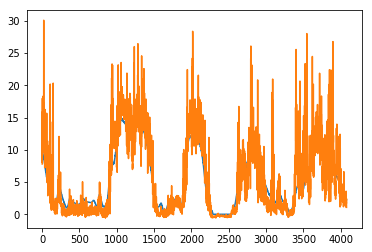

9.168751100529803
5.570485523191393
4.89380004437646
4.543119812305803


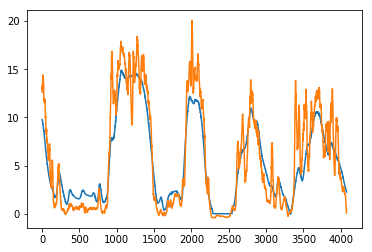

Epoch 1/1
2595/2595 [==============================] - 303s 117ms/step - loss: 5.3403
custom valid metrics
                  0
count  20758.000000
mean      13.575104
std        9.598241
min       -0.451339
25%        5.371691
50%       13.884026
75%       18.905782
max       37.730247
25.01218


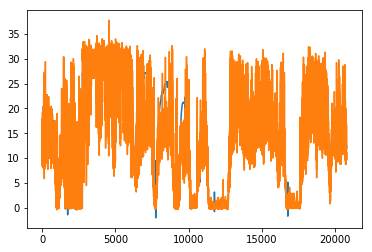

25.012179640489624
17.383383523437868
16.373545589462317
15.97280902100652


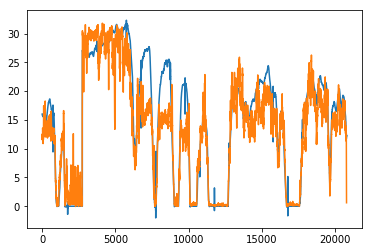

comma train metrics
                  0
count  16320.000000
mean      15.402450
std       10.035113
min       -0.409172
25%        6.637702
50%       14.583153
75%       25.484667
max       51.227310
56.714127


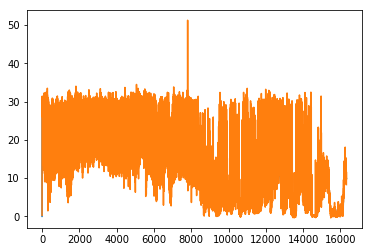

56.714127361632855
34.33592993007815
30.455776797460445
28.721169409999185


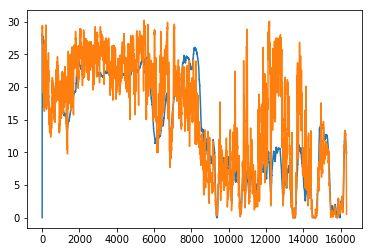

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.224189
std       4.426657
min      -0.346907
25%       1.357393
50%       4.082650
75%       8.385679
max      27.541996
3.7214575


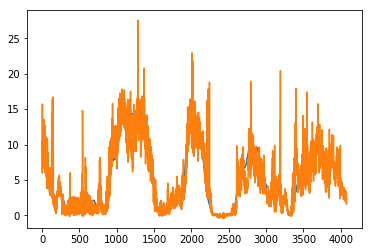

3.721457472388305
2.0452918080568248
1.822048840810057
1.7141474816161006


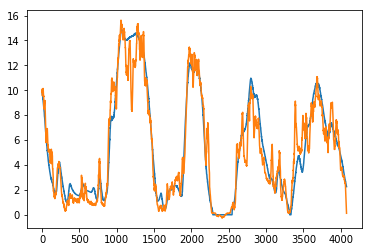

Epoch 1/1
2595/2595 [==============================] - 302s 116ms/step - loss: 4.9004
custom valid metrics
                  0
count  20758.000000
mean      13.827511
std        9.929179
min       -0.344446
25%        4.818578
50%       13.823957
75%       21.002160
max       33.625519
25.943327


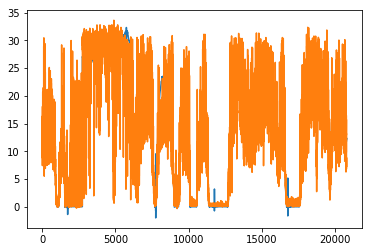

25.943325350953927
17.09970258047119
15.867960283670422
15.348052044906463


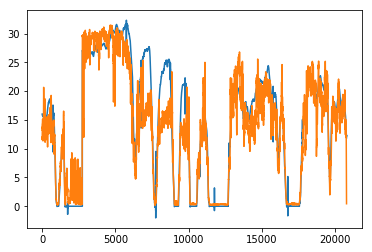

comma train metrics
                  0
count  16320.000000
mean      15.508766
std       10.626166
min       -0.229560
25%        4.449068
50%       15.834094
75%       26.460945
max       32.879059
47.74708


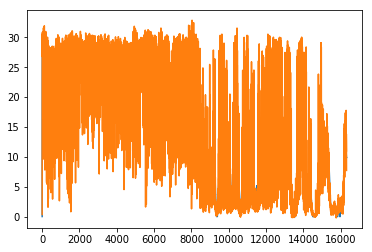

47.747079827988436
30.419663212983764
27.786095430079165
26.56100780440161


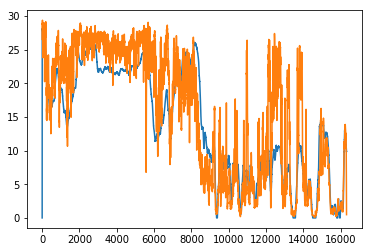

comma valid metrics
128/128 [==============================] - 1s 11ms/step
                 0
count  4080.000000
mean      4.997459
std       4.284461
min      -0.056654
25%       1.536144
50%       3.658576
75%       7.664670
max      27.827244
3.3372166


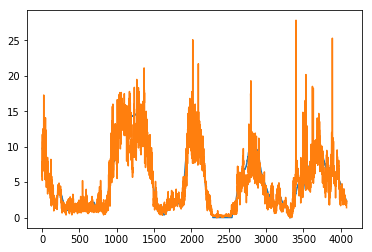

3.3372166611094713
1.8926638147909063
1.6634533999888337
1.5688334535994772


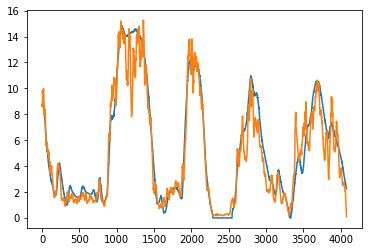

In [24]:
#custom data generalization to comma data

model_flat = build_model_flat(time_history)
for i in range(10):
    model_flat.fit_generator(train_generator, epochs = 1)
    val_predictions = model_flat.predict_generator(valid_generator)[:, 0]
    print("custom valid metrics")
    evaluate_metrics(np.array(speed_data)[val_indexes], val_predictions)
    
    print("comma train metrics")
    #model_flat.fit_generator(comma_train_generator, epochs = 1)
    comma_train_predictions = model_flat.predict_generator(comma_train_generator_no_shuf)[:, 0]
    evaluate_metrics(np.array(np.array(comma_speed_data)[comma_train_indexes_no_shuf]), comma_train_predictions)
    
    print("comma valid metrics")
    comma_val_predictions = model_flat.predict_generator(comma_val_generator_no_shuf, verbose=1)[:, 0]
    evaluate_metrics(np.array(comma_speed_data)[comma_val_indexes_no_shuf], comma_val_predictions)
    

    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 160, 2)   0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 160, 2)   0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 50, 160, 2)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 158, 8)   152         dropout_1[0][0]                  
__________________________________________________________________________________________________
conv2d_8 (

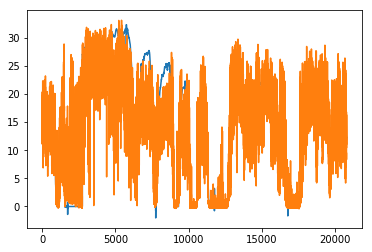

29.507312554538387
23.19926812534168
21.987721369910485
21.308532228987666


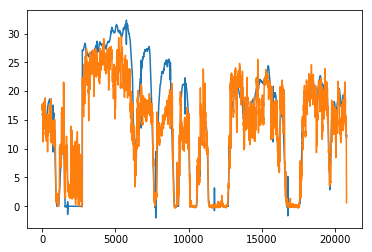

comma train metrics
Epoch 1/1
510/510 [==============================] - 57s 111ms/step - loss: 8.0948
                  0
count  16320.000000
mean      13.072823
std        7.176328
min       -0.035048
25%        6.716531
50%       13.388414
75%       20.105792
max       27.885349
6.723514


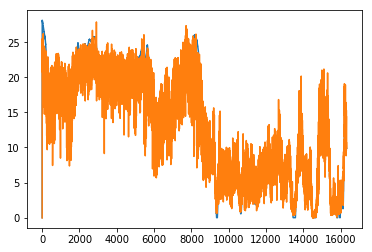

6.723513565363468
4.480657108737338
4.223012720175571
4.138897162216263


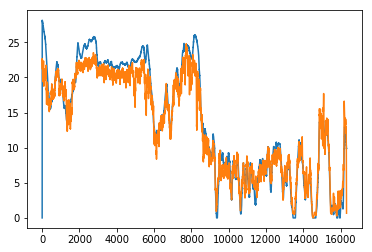

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      6.894134
std       4.824439
min      -0.034928
25%       2.809007
50%       6.102309
75%      10.673641
max      21.564970
6.9920735


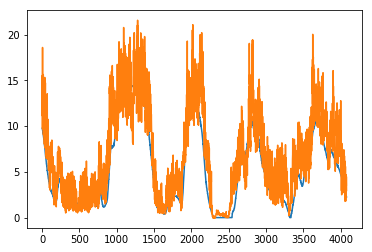

6.992073842999053
5.359201097731088
5.02898566913946
4.812527337259852


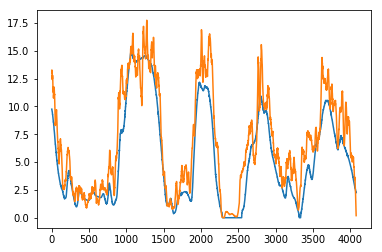

Epoch 1/1
2595/2595 [==============================] - 302s 116ms/step - loss: 15.4088
custom valid metrics
                  0
count  20758.000000
mean      13.776100
std        9.249952
min       -1.638174
25%        5.496902
50%       14.811982
75%       19.674289
max       33.517780
20.307644


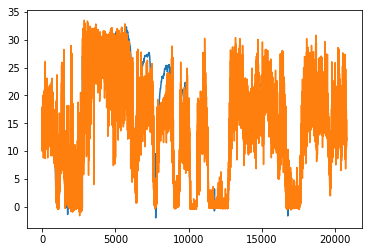

20.307643291729892
15.238089127899556
14.461986687832725
14.107644578352621


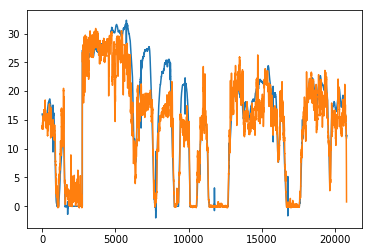

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 111ms/step - loss: 7.3285
                  0
count  16320.000000
mean      11.760562
std        7.301672
min        0.074102
25%        5.478792
50%       10.442215
75%       19.304999
max       26.781067
10.987363


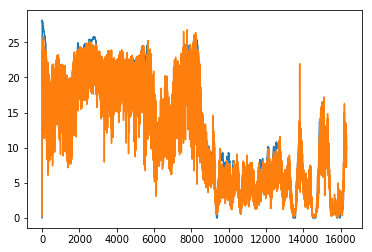

10.987362611627214
8.540092036083514
8.258114752389503
8.16627285078633


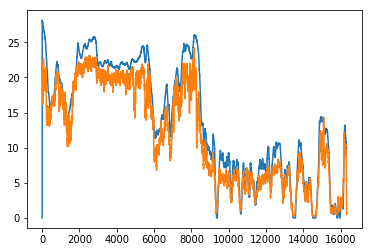

comma valid metrics
128/128 [==============================] - 1s 11ms/step
                 0
count  4080.000000
mean      5.261494
std       3.636881
min       0.121994
25%       2.242134
50%       4.621308
75%       7.784799
max      19.824226
3.5351539


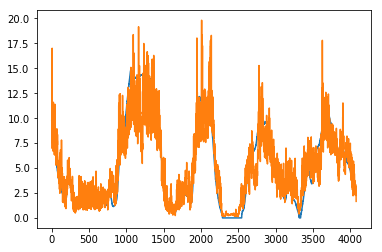

3.535153876532384
2.609603365892527
2.423621439855905
2.31389325102122


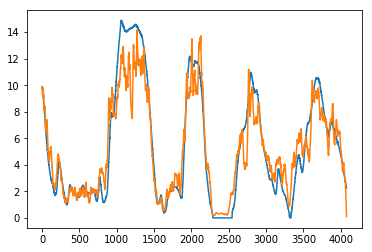

Epoch 1/1
2595/2595 [==============================] - 303s 117ms/step - loss: 12.0350
custom valid metrics
                  0
count  20758.000000
mean      14.379295
std       10.055785
min       -0.734843
25%        5.697912
50%       14.934753
75%       21.416675
max       35.428970
22.184057


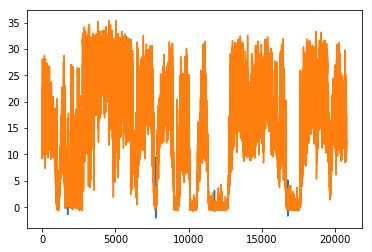

22.18405678835888
13.252287593025043
12.045088296697324
11.447811790142756


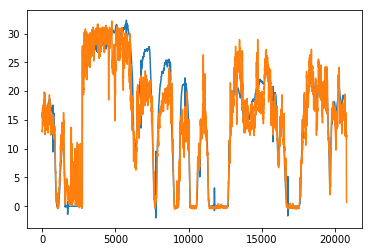

comma train metrics
Epoch 1/1
510/510 [==============================] - 58s 113ms/step - loss: 6.1820
                  0
count  16320.000000
mean      12.989135
std        7.428801
min       -0.455068
25%        6.760519
50%       13.282944
75%       20.013817
max       27.651060
5.30918


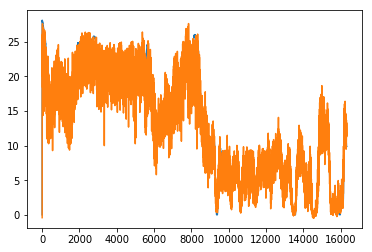

5.309179537855596
3.4820165381940984
3.2796018720053812
3.217232152089512


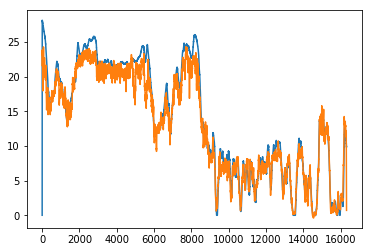

comma valid metrics
128/128 [==============================] - 1s 11ms/step
                 0
count  4080.000000
mean      6.343243
std       4.670629
min      -0.469625
25%       2.011463
50%       5.775583
75%      10.339406
max      20.931175
4.377405


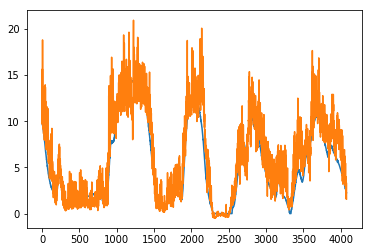

4.377405193498927
3.344099766997473
3.1486519971597007
3.0307094302951607


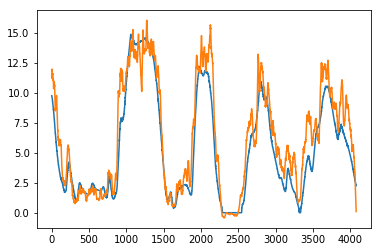

Epoch 1/1
2595/2595 [==============================] - 302s 117ms/step - loss: 10.3427
custom valid metrics
                  0
count  20758.000000
mean      15.013871
std        9.792003
min       -0.412912
25%        5.633837
50%       16.611404
75%       22.592767
max       33.354801
18.842575


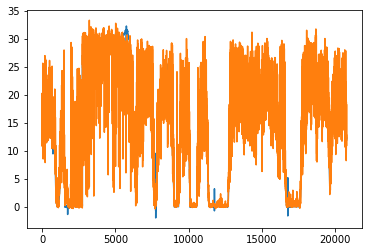

18.842575720994546
11.810537943890555
10.782874077179768
10.286440129511249


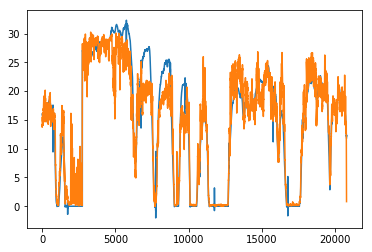

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 5.9965
                  0
count  16320.000000
mean      12.302861
std        7.273934
min       -0.837974
25%        6.260146
50%       12.112246
75%       19.576131
max       29.303280
6.7940197


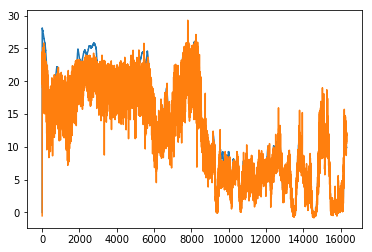

6.794019714898935
5.028117009637216
4.84019560734861
4.788946539063333


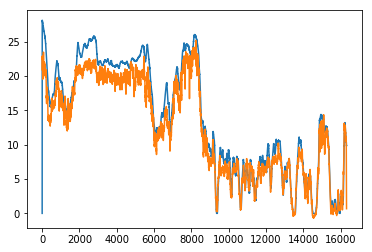

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.953652
std       4.511561
min      -0.899781
25%       1.775303
50%       5.610884
75%       9.721671
max      21.612698
4.5258484


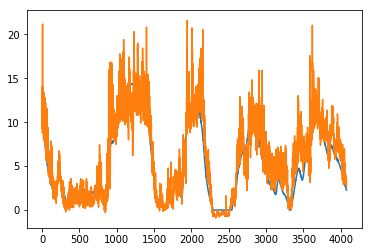

4.525847969168691
3.255490827497226
3.031721013344979
2.894414972447394


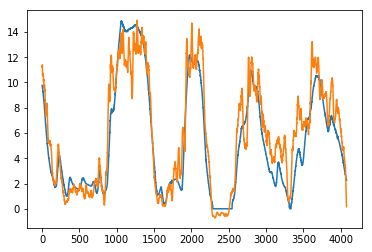

Epoch 1/1
2595/2595 [==============================] - 308s 119ms/step - loss: 8.8969
custom valid metrics
                  0
count  20758.000000
mean      14.068321
std        9.778350
min       -1.399210
25%        4.908851
50%       14.631614
75%       22.486871
max       32.062241
23.174736


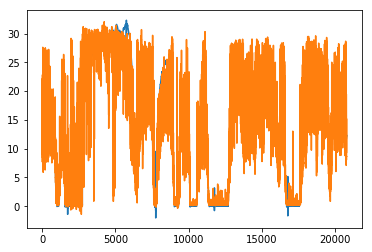

23.17473461856535
15.946045585489337
14.869974668685197
14.340496313552263


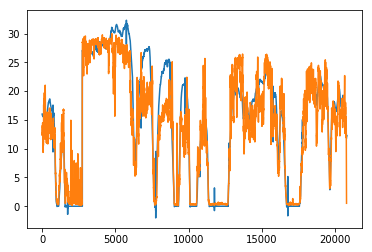

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 5.2615
                  0
count  16320.000000
mean      12.089419
std        7.221462
min       -0.744553
25%        5.831472
50%       12.600992
75%       19.157114
max       26.582300
7.197906


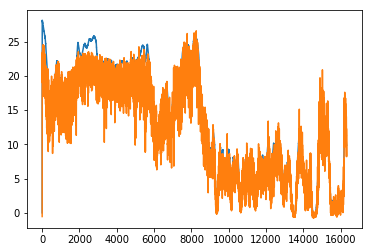

7.197905987528992
5.778487622621336
5.604891079023994
5.556644909595584


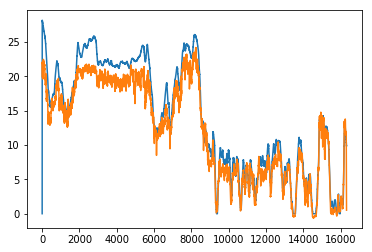

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.570291
std       4.716297
min      -0.791640
25%       1.249955
50%       4.625687
75%       9.490632
max      21.645964
3.6388175


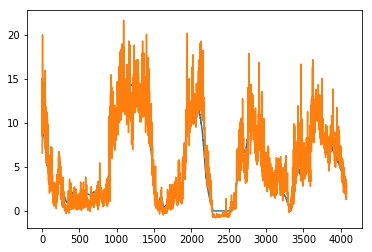

3.6388177805391533
2.319166502736491
2.0771603747485776
1.9394035285126237


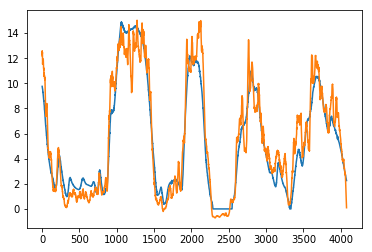

Epoch 1/1
2595/2595 [==============================] - 302s 116ms/step - loss: 7.7342
custom valid metrics
                  0
count  20758.000000
mean      14.549662
std       10.170902
min       -0.192624
25%        5.260303
50%       15.089863
75%       22.329665
max       35.004498
22.044857


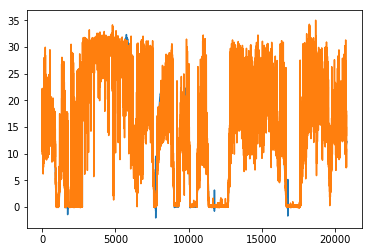

22.044857681289205
13.922916808783688
12.730557537429736
12.174509150814519


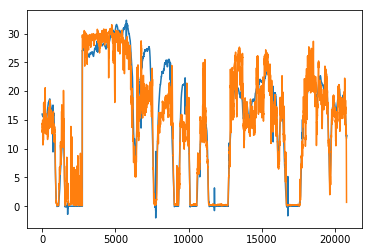

comma train metrics
Epoch 1/1
510/510 [==============================] - 57s 111ms/step - loss: 5.1635
                  0
count  16320.000000
mean      11.909679
std        7.123816
min       -0.611113
25%        5.816347
50%       11.692956
75%       18.979415
max       27.573065
8.086266


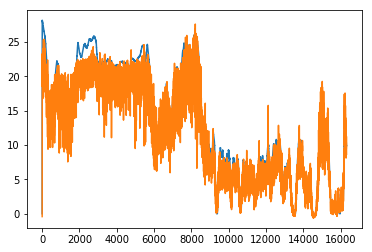

8.086265889552715
6.551112257512042
6.371128718380306
6.324863124788477


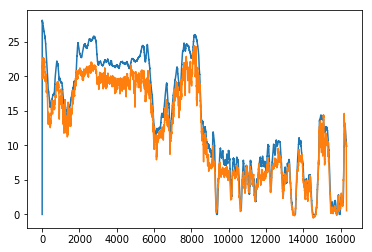

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.275988
std       4.245433
min      -0.697218
25%       1.769301
50%       4.238162
75%       8.181270
max      20.153111
3.2598329


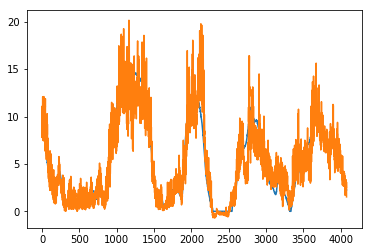

3.2598328702239803
2.1890673731489905
1.9697383074438954
1.8292048927746163


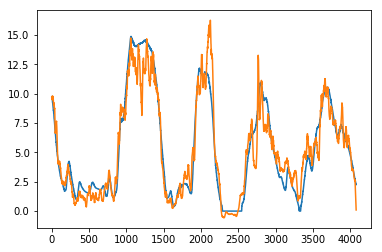

Epoch 1/1
2595/2595 [==============================] - 303s 117ms/step - loss: 7.1070
custom valid metrics
                  0
count  20758.000000
mean      14.602924
std        9.706907
min       -0.175857
25%        6.388936
50%       15.263957
75%       21.930487
max       33.667919
24.971361


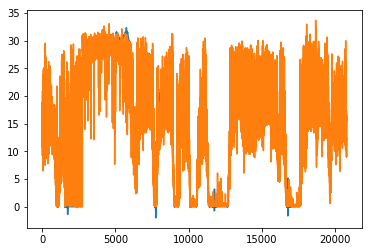

24.971360628212253
16.97633932676208
15.6069879264671
14.909127443306526


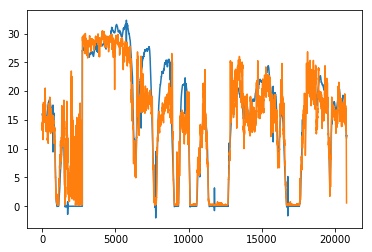

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 111ms/step - loss: 4.8203
                  0
count  16320.000000
mean      12.937708
std        7.683797
min       -0.814495
25%        6.391232
50%       12.505485
75%       20.636657
max       30.252085
4.1543627


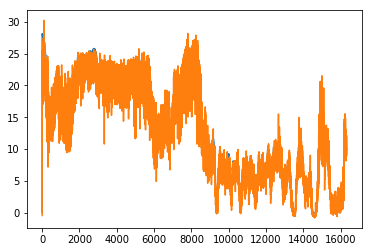

4.154362338616766
2.5984214209453094
2.4103374946779046
2.361080065929245


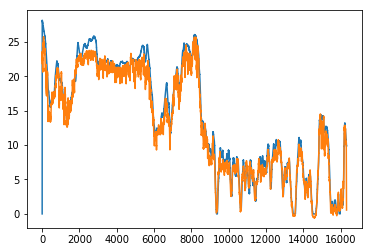

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.517526
std       4.293304
min      -0.725825
25%       1.947694
50%       4.681293
75%       8.518224
max      23.067289
3.980416


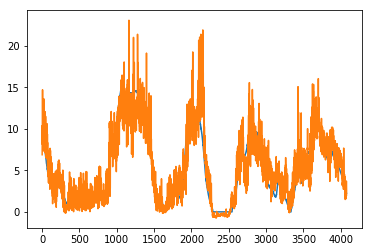

3.9804161645812646
2.6286059805567343
2.3341272372926807
2.1526708400423353


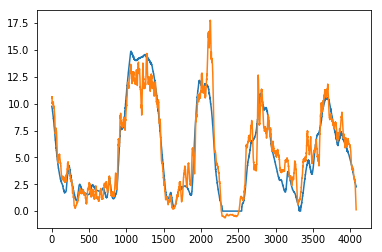

Epoch 1/1
2595/2595 [==============================] - 303s 117ms/step - loss: 6.6889
custom valid metrics
                  0
count  20758.000000
mean      13.702237
std       10.056150
min       -0.374844
25%        3.844413
50%       13.867291
75%       19.886783
max       33.969387
30.688229


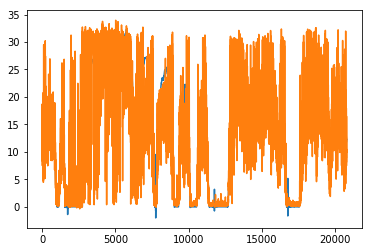

30.6882297619987
19.291209542696432
17.881412939744298
17.256258334998073


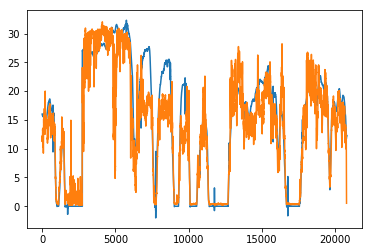

comma train metrics
Epoch 1/1
510/510 [==============================] - 57s 111ms/step - loss: 4.7137
                  0
count  16320.000000
mean      12.431340
std        7.547757
min       -0.644091
25%        6.000398
50%       11.940583
75%       20.120925
max       28.660133
5.362582


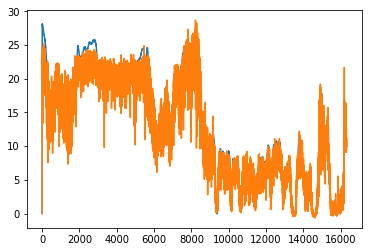

5.362582360711632
4.0001115843570325
3.857597279719128
3.8248964654332074


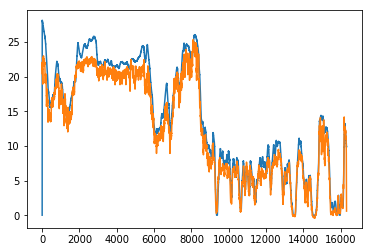

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.354141
std       4.369025
min      -0.535967
25%       1.538657
50%       4.573382
75%       8.441113
max      22.646654
3.8688765


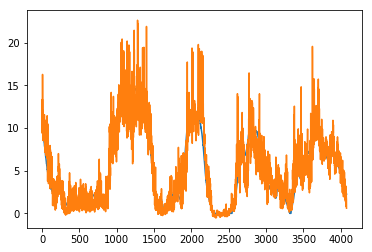

3.868876521276648
2.3582264732632523
2.0861659116217455
1.9321658679907172


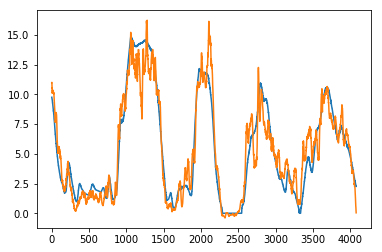

Epoch 1/1
2595/2595 [==============================] - 303s 117ms/step - loss: 6.0334
custom valid metrics
                  0
count  20758.000000
mean      14.310087
std        9.943631
min       -0.598732
25%        4.963765
50%       14.728746
75%       24.546067
max       30.836607
26.165928


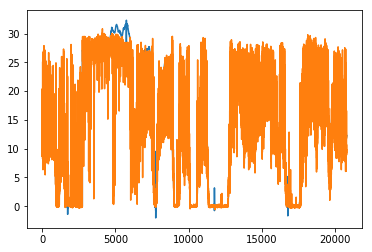

26.165926389498892
18.418970724761145
17.302241267036397
16.722625816840598


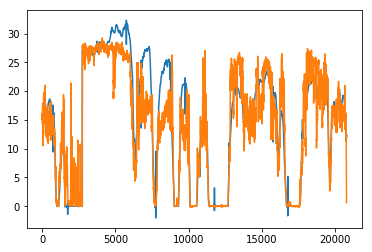

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 4.1806
                  0
count  16320.000000
mean      12.264591
std        7.424264
min       -0.311369
25%        5.751203
50%       12.021769
75%       19.877966
max       27.998728
6.2181454


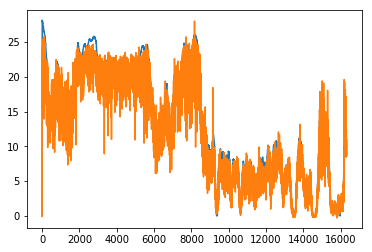

6.218145091293643
4.821792873676048
4.663869288416846
4.616014738815698


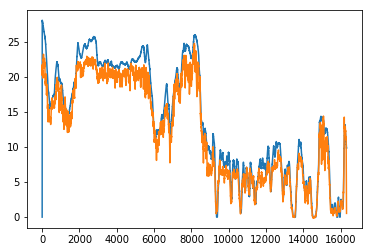

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.252280
std       4.368647
min      -0.226972
25%       1.482078
50%       4.128331
75%       7.927032
max      21.719849
4.01536


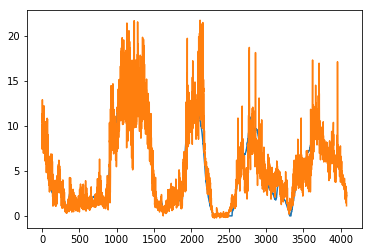

4.015359878293631
2.5201829451691915
2.2178590482307783
2.0282764608622306


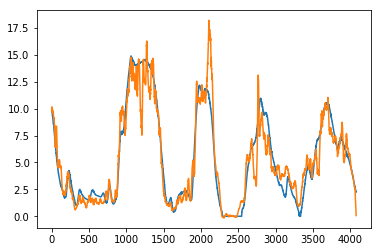

Epoch 1/1
2595/2595 [==============================] - 302s 116ms/step - loss: 5.5568
custom valid metrics
                  0
count  20758.000000
mean      13.765588
std        9.701935
min       -0.685107
25%        4.627306
50%       15.035402
75%       19.780481
max       32.375340
22.263353


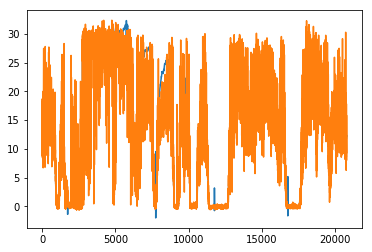

22.263354374856764
15.26226034892651
14.341245012519295
13.924395370614267


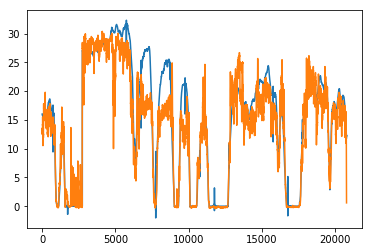

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 3.9336
                  0
count  16320.000000
mean      12.762781
std        7.536485
min        0.097405
25%        6.226205
50%       12.634660
75%       20.360574
max       27.815729
4.305194


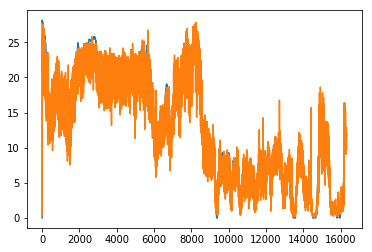

4.305193706217945
2.969189496176061
2.8050550246166575
2.7666702230932376


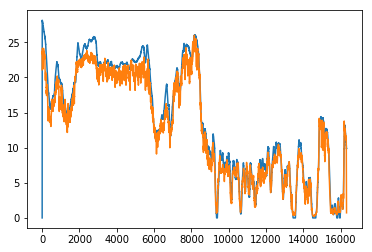

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.656742
std       4.562359
min       0.164475
25%       1.611356
50%       4.374370
75%       9.066085
max      23.285000
4.549594


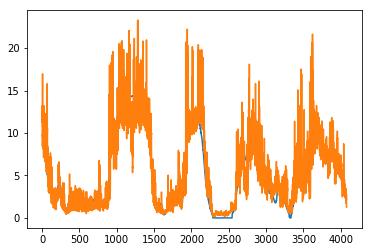

4.549594348975387
2.5854768915881814
2.2300793981730562
2.0353749161656465


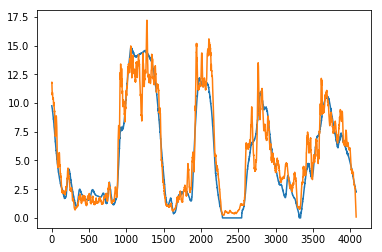

In [25]:
#custom data + comma data  to comma data
model_flat = build_model_flat(time_history)
for i in range(10):
    model_flat.fit_generator(train_generator, epochs = 1)
    val_predictions = model_flat.predict_generator(valid_generator)[:, 0]
    print("custom valid metrics")
    evaluate_metrics(np.array(speed_data)[val_indexes], val_predictions)
    
    print("comma train metrics")
    model_flat.fit_generator(comma_train_generator, epochs = 1)
    comma_train_predictions = model_flat.predict_generator(comma_train_generator_no_shuf)[:, 0]
    evaluate_metrics(np.array(np.array(comma_speed_data)[comma_train_indexes_no_shuf]), comma_train_predictions)
    
    print("comma valid metrics")
    comma_val_predictions = model_flat.predict_generator(comma_val_generator_no_shuf, verbose=1)[:, 0]
    evaluate_metrics(np.array(comma_speed_data)[comma_val_indexes_no_shuf], comma_val_predictions)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 160, 2)   0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 160, 2)   0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 50, 160, 2)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 158, 8)   152         dropout_1[0][0]                  
__________________________________________________________________________________________________
conv2d_8 (

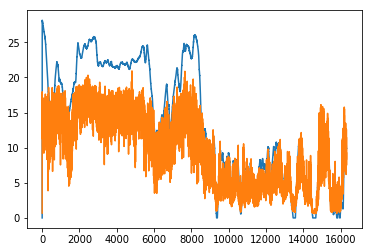

32.648448269544645
31.259991942593036
31.10755694560097
31.061095392410618


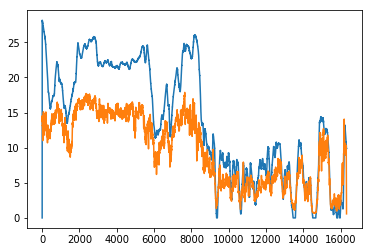

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.612256
std       3.432619
min       0.683993
25%       2.762928
50%       4.920800
75%       8.213849
max      17.000557
4.6424026


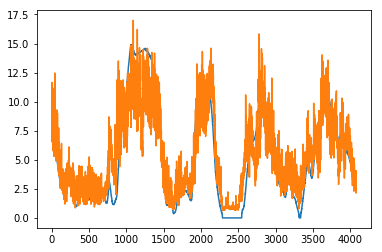

4.642402716301684
3.681760491699756
3.5158733478574096
3.4298617545400276


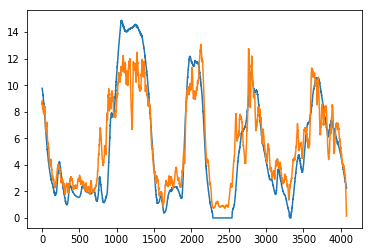

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 111ms/step - loss: 7.4842
                  0
count  16320.000000
mean      12.791262
std        7.150596
min       -0.024438
25%        6.465362
50%       13.444459
75%       19.525081
max       28.031649
6.9235477


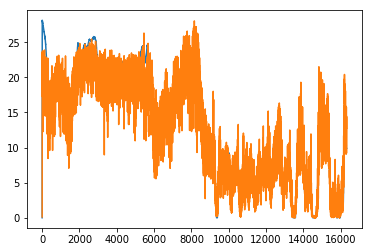

6.923547834360378
4.9526532003437085
4.740200558140947
4.657430513361753


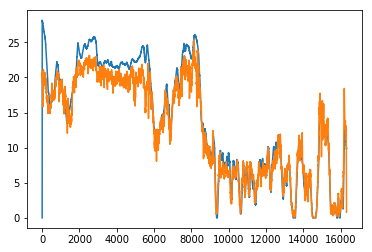

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      6.946587
std       5.120601
min      -0.013439
25%       2.492838
50%       6.208592
75%      10.865501
max      22.957787
8.701394


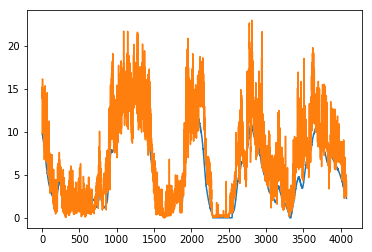

8.701393981605271
6.570758559259823
6.194925538613017
5.990886040367547


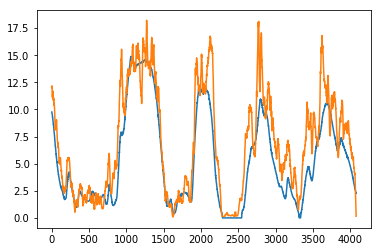

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 5.6354
                  0
count  16320.000000
mean      12.130611
std        6.707488
min        0.375817
25%        6.364830
50%       12.034301
75%       18.633373
max       28.063463
9.180965


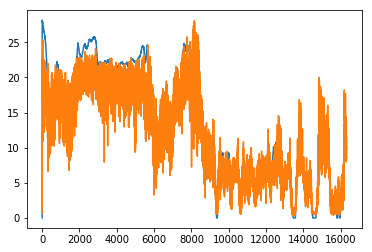

9.180966244826203
7.5292304165829895
7.360410561352869
7.301607917472587


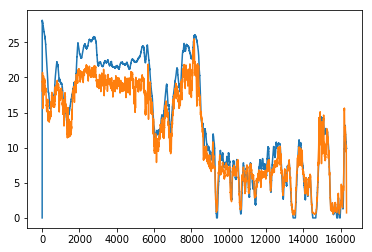

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      6.559011
std       4.363907
min       0.432704
25%       2.819230
50%       6.005059
75%       9.472658
max      22.806417
7.16998


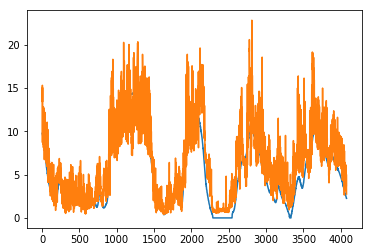

7.169980192991559
5.286418254084487
4.904829261864009
4.687166855261428


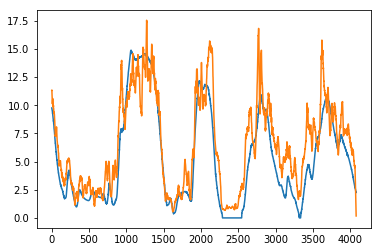

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 4.5893
                  0
count  16320.000000
mean      12.222016
std        7.179420
min        0.121495
25%        5.750545
50%       12.234934
75%       19.191762
max       28.244871
7.5738177


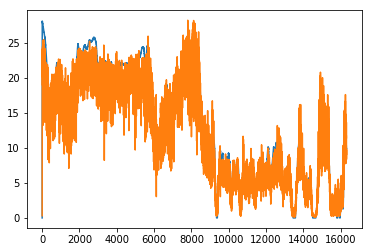

7.5738178505721825
5.845527284178848
5.627343148100088
5.554595066236493


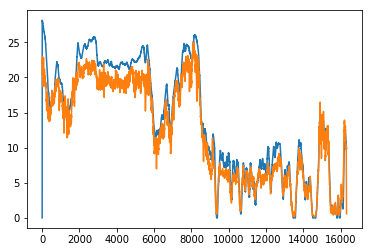

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      6.503132
std       4.733004
min       0.248675
25%       2.674194
50%       5.464917
75%       9.507252
max      22.963648
8.184304


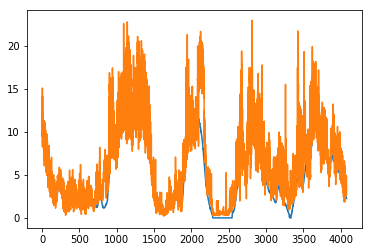

8.184304379877922
5.645647115357355
5.210705644243867
4.9824173164786645


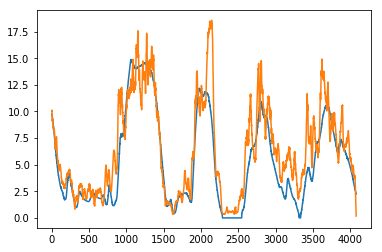

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 3.8370
                  0
count  16320.000000
mean      12.431788
std        7.363963
min       -0.435846
25%        6.444968
50%       11.513696
75%       19.639066
max       28.156073
6.5865273


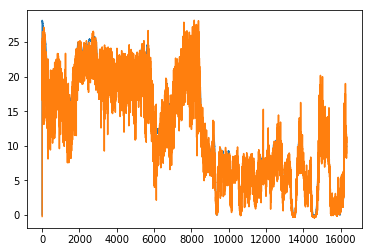

6.586527195853865
4.877816778884336
4.652452337174063
4.586109482414813


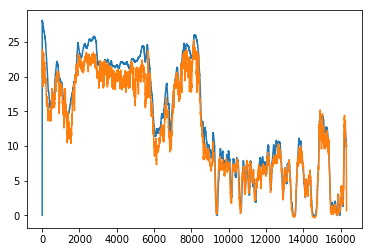

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      6.381602
std       4.924456
min      -0.269425
25%       2.012939
50%       6.000872
75%       9.579617
max      25.664455
7.5292788


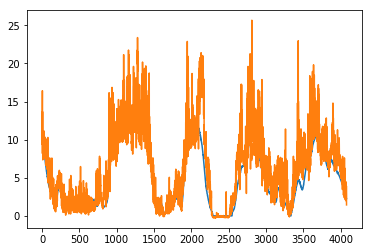

7.5292785216738825
5.447406267612745
5.064927151660058
4.842856694581332


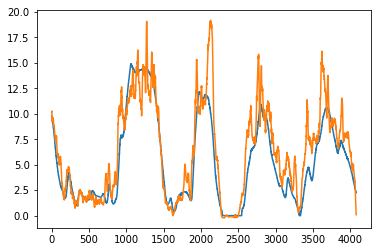

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 3.3514
                  0
count  16320.000000
mean      13.066232
std        7.695266
min        0.050726
25%        6.296029
50%       13.173187
75%       20.482433
max       32.580940
4.3429737


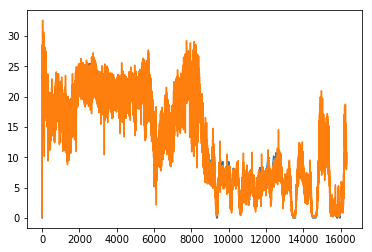

4.342973767457334
2.6822558824815874
2.432799801236746
2.358543030535463


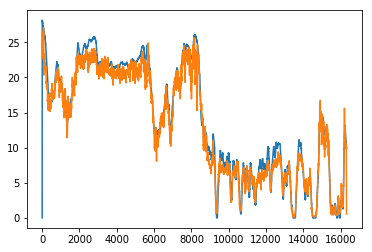

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      6.350765
std       4.503504
min       0.186693
25%       2.563673
50%       5.902730
75%       9.053183
max      24.907808
7.88831


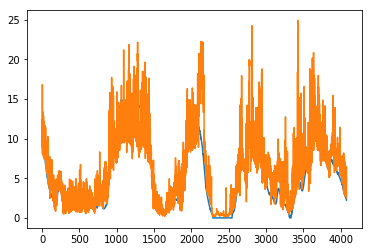

7.888310417926975
5.537545825334339
5.134736606405092
4.889284178075502


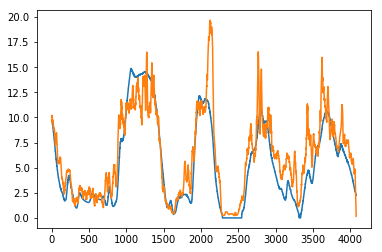

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 2.9791
                  0
count  16320.000000
mean      12.486477
std        7.723776
min       -0.135199
25%        5.776414
50%       11.991406
75%       20.326088
max       28.543520
6.965788


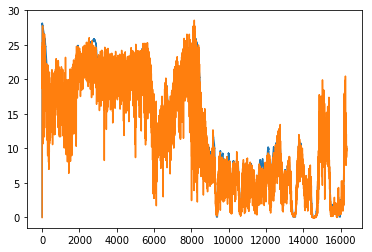

6.96578766641422
4.784991970962732
4.54476219563944
4.460484691409621


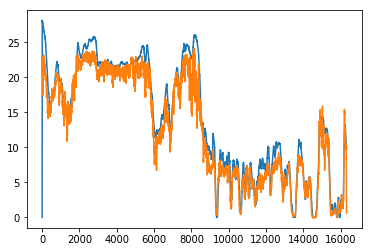

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.339759
std       4.466778
min      -0.082092
25%       1.391995
50%       4.343651
75%       8.280523
max      23.982548
5.0593367


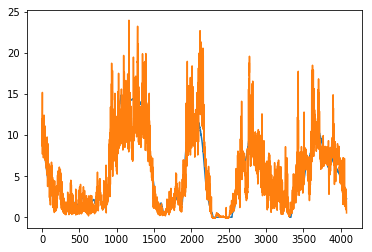

5.0593369433349125
3.3962895755606857
3.0683886458133602
2.8655805634751976


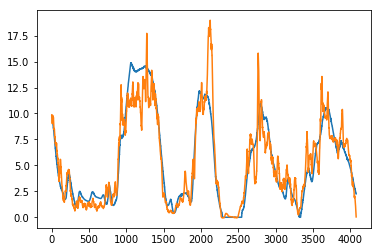

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 2.8395
                  0
count  16320.000000
mean      12.434384
std        7.246176
min       -0.080051
25%        6.521874
50%       12.019980
75%       19.453856
max       29.612146
5.378708


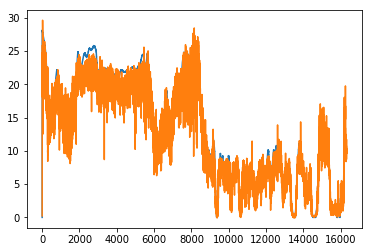

5.378707575501554
4.246104754336712
4.109361683907637
4.066895744308689


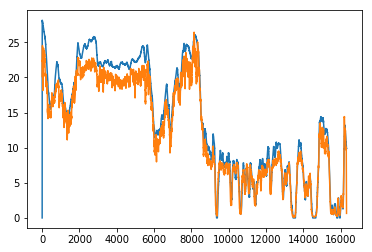

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      6.126079
std       4.594335
min       0.165220
25%       1.641220
50%       6.210513
75%       9.299317
max      24.721285
7.502925


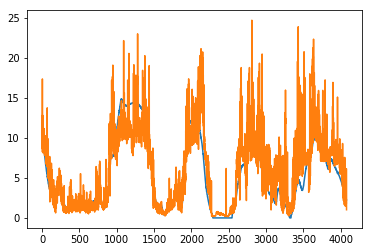

7.5029248035568665
5.2683022846635765
4.895528736310615
4.690246311701022


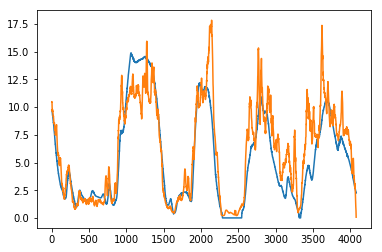

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 2.4375
                  0
count  16320.000000
mean      12.708327
std        7.454318
min       -0.458129
25%        6.420232
50%       12.648504
75%       20.087332
max       27.107164
4.1706295


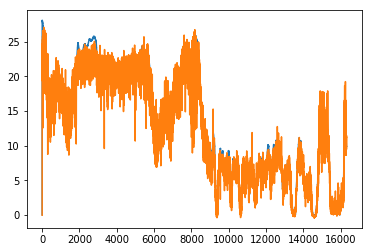

4.170629451899957
3.0903107599289026
2.965855258044128
2.9356728481779317


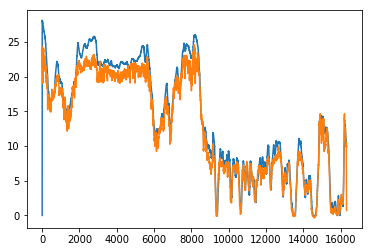

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      6.090744
std       4.756285
min      -0.159780
25%       1.857521
50%       5.572876
75%       9.239595
max      23.324913
8.163102


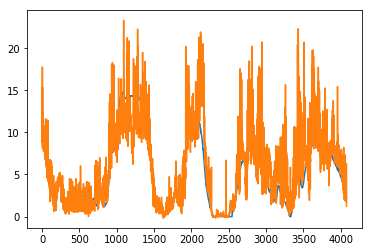

8.163102144090134
5.666429815048
5.219402888892375
4.9481909437559946


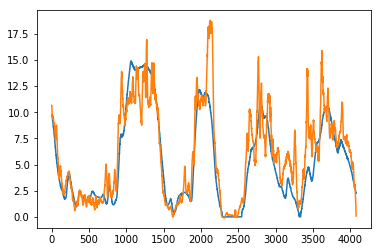

comma train metrics
Epoch 1/1
510/510 [==============================] - 56s 110ms/step - loss: 1.9965
                  0
count  16320.000000
mean      12.216035
std        7.332261
min       -0.146846
25%        5.484809
50%       12.578280
75%       19.397073
max       26.991877
5.343738


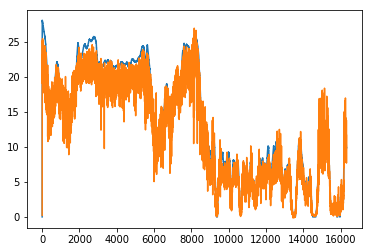

5.34373814999651
4.502549555587717
4.425473187361944
4.425924220890512


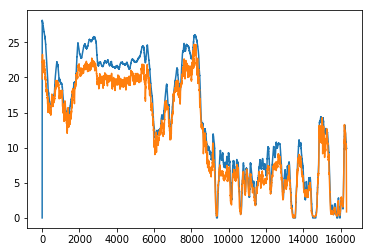

comma valid metrics
128/128 [==============================] - 1s 10ms/step
                 0
count  4080.000000
mean      5.817457
std       4.518515
min       0.204255
25%       1.757009
50%       5.153662
75%       8.655150
max      23.485546
6.569066


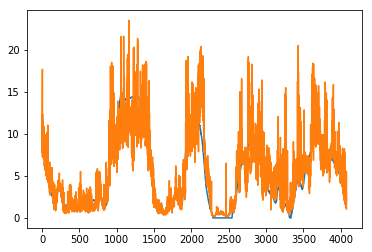

6.569065602584222
4.328698236672017
3.905920368843106
3.6528773440520377


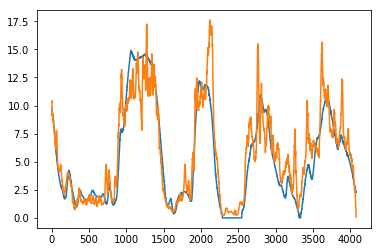

In [26]:
#comma data to comma data
model_flat = build_model_flat(time_history)
for i in range(10):
#     model_flat.fit_generator(train_generator, epochs = 1)
#     val_predictions = model_flat.predict_generator(valid_generator)[:, 0]
#     print("custom valid metrics")
#     evaluate_metrics(np.array(speed_data)[val_indexes], val_predictions)
    
    print("comma train metrics")
    model_flat.fit_generator(comma_train_generator, epochs = 1)
    comma_train_predictions = model_flat.predict_generator(comma_train_generator_no_shuf)[:, 0]
    evaluate_metrics(np.array(np.array(comma_speed_data)[comma_train_indexes_no_shuf]), comma_train_predictions)
    
    print("comma valid metrics")
    comma_val_predictions = model_flat.predict_generator(comma_val_generator_no_shuf, verbose=1)[:, 0]
    evaluate_metrics(np.array(comma_speed_data)[comma_val_indexes_no_shuf], comma_val_predictions)

In [91]:
def build_model(history_size):
    k.clear_session()
    frame_inp = Input(shape=(history_size, 224, 224, 3))
    op_flow_inp = Input(shape=(history_size, 224, 224, 3))
    filter_size = (3,3)
    #frame = TimeDistributed(BatchNormalization())(frame_inp)
    frame = TimeDistributed(SpatialDropout2D(.2))(frame_inp)
    frame = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(16, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    #frame = TimeDistributed(SpatialDropout2D(.2))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(GlobalMaxPool2D())(frame)
    
    op_flow = TimeDistributed(BatchNormalization())(op_flow_inp)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(64, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(128, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow_max = TimeDistributed(GlobalMaxPool2D())(op_flow)
    op_flow_avg = TimeDistributed(GlobalAvgPool2D())(op_flow)
    
    conc = concatenate([op_flow_max, op_flow_avg,
                       #frame
                       ])
    #conc = BatchNormalization()(conc)
    conc = SpatialDropout1D(.2)(conc)
    conc = CuDNNGRU(256)(conc)
    conc = Dense(100, activation = "relu")(conc)
    conc = Dropout(.2)(conc)
    conc = Dense(50, activation = "relu")(conc)
    conc = Dropout(.1)(conc)
    result = Dense(1, activation='linear')(conc)
    
    model = Model(inputs=[frame_inp, op_flow_inp], outputs=[result])
    print(model.summary())
    model.compile(loss="mse", optimizer='adam')

    return model

In [86]:
model = build_model(time_history)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 224, 224,  0                                            
__________________________________________________________________________________________________
time_distributed_13 (TimeDistri (None, 1, 224, 224,  12          input_2[0][0]                    
__________________________________________________________________________________________________
time_distributed_14 (TimeDistri (None, 1, 224, 224,  0           time_distributed_13[0][0]        
__________________________________________________________________________________________________
time_distributed_15 (TimeDistri (None, 1, 222, 222,  112         time_distributed_14[0][0]        
__________________________________________________________________________________________________
time_distr

In [87]:
hist = model.fit_generator(train_generator, validation_data=valid_generator, epochs = 10, 
                           callbacks=[EarlyStopping(patience=3), ModelCheckpoint(filepath="rnn_model.ckpt", save_weights_only=False)])

Epoch 1/10
1061/1061 [==============================] - 619s 584ms/step - loss: 40.8469 - val_loss: 141.1516
Epoch 2/10
1061/1061 [==============================] - 614s 579ms/step - loss: 17.7586 - val_loss: 91.3322
Epoch 3/10
1061/1061 [==============================] - 620s 584ms/step - loss: 14.0745 - val_loss: 91.2476
Epoch 4/10
1061/1061 [==============================] - 636s 600ms/step - loss: 12.2106 - val_loss: 77.1058
Epoch 5/10
1061/1061 [==============================] - 621s 586ms/step - loss: 10.8576 - val_loss: 98.6059
Epoch 6/10
 334/1061 [========>.....................] - ETA: 5:58 - loss: 10.2859

KeyboardInterrupt: 

In [26]:
hist2 = model_flat.fit_generator(train_generator, validation_data=valid_generator, epochs = 10)

Epoch 1/10
850/850 [==============================] - 64s 75ms/step - loss: 10.2186 - val_loss: 7.8661
Epoch 2/10
850/850 [==============================] - 54s 63ms/step - loss: 6.9825 - val_loss: 10.1133
Epoch 3/10
850/850 [==============================] - 52s 61ms/step - loss: 6.1236 - val_loss: 14.2986
Epoch 4/10
850/850 [==============================] - 52s 61ms/step - loss: 5.2178 - val_loss: 12.8146
Epoch 5/10
850/850 [==============================] - 52s 61ms/step - loss: 4.7625 - val_loss: 9.2727
Epoch 6/10
329/850 [==========>...................] - ETA: 26s - loss: 4.4986

KeyboardInterrupt: 

In [30]:
hist2 = model_flat.fit_generator(train_generator, validation_data=valid_generator, epochs = 10)

Epoch 1/10
1020/1020 [==============================] - 61s 59ms/step - loss: 9.1252 - val_loss: 6.3036
Epoch 2/10
1020/1020 [==============================] - 60s 59ms/step - loss: 5.7693 - val_loss: 5.7843
Epoch 3/10
1020/1020 [==============================] - 60s 59ms/step - loss: 5.0111 - val_loss: 8.4845
Epoch 4/10
1020/1020 [==============================] - 60s 59ms/step - loss: 4.5018 - val_loss: 9.0041
Epoch 5/10
1020/1020 [==============================] - 60s 58ms/step - loss: 4.5581 - val_loss: 6.3973
Epoch 6/10
1020/1020 [==============================] - 60s 58ms/step - loss: 4.3193 - val_loss: 7.4391
Epoch 7/10
1020/1020 [==============================] - 59s 58ms/step - loss: 4.0120 - val_loss: 17.6570
Epoch 8/10
1020/1020 [==============================] - 60s 59ms/step - loss: 3.4943 - val_loss: 9.9679
Epoch 9/10
1020/1020 [==============================] - 60s 58ms/step - loss: 3.6226 - val_loss: 10.5491
Epoch 10/10
1020/1020 [==============================] - 60s 5

In [53]:
def build_model_frame(history_size):
    k.clear_session()
    frame_inp = Input(shape=(history_size, 224, 224, 3))
    op_flow_inp = Input(shape=(history_size, 224, 224, 3))
    filter_size = (3,3)
    base_mod = Xception(weights='imagenet', include_top=False, input_shape = (224,224,3))
    for l in base_mod.layers: 
        l.trainable=False
    frame = TimeDistributed(BatchNormalization())(frame_inp)
    frame = TimeDistributed(base_mod)(frame)
    #frame = Reshape(target_shape=(history_size, 2048))(frame)
    frame = TimeDistributed(Conv2D(128, (1,1), activation = "relu"))(frame)
    frame_max = TimeDistributed(GlobalMaxPool2D())(frame)
    frame_avg = TimeDistributed(GlobalAvgPool2D())(frame)
    
    op_flow = TimeDistributed(BatchNormalization())(op_flow_inp)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(64, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(128, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow_max = TimeDistributed(GlobalMaxPool2D())(op_flow)
    op_flow_avg = TimeDistributed(GlobalAvgPool2D())(op_flow)
    
    conc = concatenate([
        #frame_max, frame_avg,
        op_flow_max, op_flow_avg
    ])
    conc = BatchNormalization()(conc)
    #conc = SpatialDropout1D(.2)(conc)
    #conc = CuDNNGRU(256)(conc)
    conc = Flatten()(conc)
    conc = Dropout(.3)(conc)
    conc = Dense(500, activation = "relu")(conc)
    conc = Dropout(.2)(conc)
    conc = Dense(100, activation = "relu")(conc)
    conc = Dropout(.1)(conc)
    result = Dense(1, activation='linear')(conc)
    
    model = Model(inputs=[frame_inp, op_flow_inp], outputs=[result])
    print(model.summary())
    model.compile(loss="mse", optimizer='adam')

    return model

In [54]:
model3 = build_model_frame(time_history)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3, 224, 224,  0                                            
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, 3, 224, 224,  12          input_2[0][0]                    
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 3, 224, 224,  0           time_distributed_6[0][0]         
__________________________________________________________________________________________________
time_distributed_8 (TimeDistrib (None, 3, 222, 222,  112         time_distributed_7[0][0]         
__________________________________________________________________________________________________
time_distr

In [55]:
hist3 = model3.fit_generator(train_generator, validation_data=valid_generator, epochs = 10)

Epoch 1/10
1020/1020 [==============================] - 163s 159ms/step - loss: 28.2054 - val_loss: 12.9030
Epoch 2/10
1020/1020 [==============================] - 160s 157ms/step - loss: 13.6002 - val_loss: 18.9242
Epoch 3/10
1020/1020 [==============================] - 158s 155ms/step - loss: 10.7904 - val_loss: 11.0065
Epoch 4/10
1020/1020 [==============================] - 159s 156ms/step - loss: 8.6554 - val_loss: 13.5720
Epoch 5/10
1020/1020 [==============================] - 160s 156ms/step - loss: 7.8862 - val_loss: 5.3888
Epoch 6/10
1020/1020 [==============================] - 161s 157ms/step - loss: 6.3103 - val_loss: 7.8890
Epoch 7/10
1020/1020 [==============================] - 160s 157ms/step - loss: 5.9375 - val_loss: 7.0740
Epoch 8/10
1020/1020 [==============================] - 160s 156ms/step - loss: 5.4968 - val_loss: 9.8594
Epoch 9/10
1020/1020 [==============================] - 160s 157ms/step - loss: 4.8999 - val_loss: 8.6684
Epoch 10/10
1020/1020 [================

In [59]:
def build_model_frame(history_size):
    k.clear_session()
    frame_inp = Input(shape=(history_size, 224, 224, 3))
    op_flow_inp = Input(shape=(history_size, 224, 224, 3))
    filter_size = (3,3)
    base_mod = Xception(weights='imagenet', include_top=False, input_shape = (224,224,3))
    for l in base_mod.layers: 
        l.trainable=False
    #frame = TimeDistributed(BatchNormalization())(frame_inp)
    frame = TimeDistributed(base_mod)(frame_inp)
    #frame = Reshape(target_shape=(history_size, 2048))(frame)
    frame = TimeDistributed(Conv2D(128, (1,1), activation = "relu"))(frame)
    frame_max = TimeDistributed(GlobalMaxPool2D())(frame)
    frame_avg = TimeDistributed(GlobalAvgPool2D())(frame)
    
    op_flow = TimeDistributed(BatchNormalization())(op_flow_inp)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(64, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(Dropout(.3))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow = TimeDistributed(Conv2D(128, filter_size, activation = "relu", data_format = "channels_last"))(op_flow)
    op_flow = TimeDistributed(MaxPool2D())(op_flow)
    op_flow_max = TimeDistributed(GlobalMaxPool2D())(op_flow)
    op_flow_avg = TimeDistributed(GlobalAvgPool2D())(op_flow)
    
    conc = concatenate([
        frame_max, frame_avg,
        #op_flow_max, op_flow_avg
    ])
    conc = BatchNormalization()(conc)
    #conc = SpatialDropout1D(.2)(conc)
    #conc = CuDNNGRU(256)(conc)
    conc = Flatten()(conc)
    conc = Dropout(.3)(conc)
    conc = Dense(500, activation = "relu")(conc)
    conc = Dropout(.2)(conc)
    conc = Dense(100, activation = "relu")(conc)
    conc = Dropout(.1)(conc)
    result = Dense(1, activation='linear')(conc)
    
    model = Model(inputs=[frame_inp, op_flow_inp], outputs=[result])
    print(model.summary())
    model.compile(loss="mse", optimizer='adam')

    return model

In [60]:
model4 = build_model_frame(time_history)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 224, 224,  0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 3, 7, 7, 2048 20861480    input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 3, 7, 7, 128) 262272      time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 3, 128)       0           time_distributed_2[0][0]         
__________________________________________________________________________________________________
time_distr

In [61]:
hist4 = model4.fit_generator(train_generator, validation_data=valid_generator, epochs = 10)

Epoch 1/10
1020/1020 [==============================] - 278s 273ms/step - loss: 13.5584 - val_loss: 86.6192
Epoch 2/10
 146/1020 [===>..........................] - ETA: 3:08 - loss: 7.3752

KeyboardInterrupt: 